# Génération de la Frontière Efficiente de Markowitz

Ce notebook illustre l'utilisation de la méthode de scalarisation pour approximer la frontière efficiente d'un portefeuille d'actions du secteur Energie.


In [8]:
import matplotlib.pyplot as plt
from scipy.constants import sigma
from scipy.optimize import minimize
import os
import pandas as pd
import cvxpy as cp
import numpy as np

from src.level1.functions import f_returns, f_mu, f_sigma

# Charger les données
df = pd.read_csv('../datasets/Information_Technology.csv', index_col=0, parse_dates=True)

for file in os.listdir('../datasets/'):
    if file.endswith('.csv') and 'Information_Technology' not in file:
        temp_df = pd.read_csv(os.path.join('../datasets/', file), index_col=0, parse_dates=True)
        df = df.join(temp_df, how='inner')

In [9]:
df

,AAPL,MSFT,NVDA,AVGO,AMD,INTC,QCOM,TXN,MU,ORCL,...,WELL,EQIX,NEE,DUK,SO,D,AEP,EXC,SRE,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,24.237545,39.858456,0.483038,7.574802,2.670000,27.896452,54.612610,39.557953,33.919167,37.583099,...,50.148026,175.042114,20.032856,53.362503,30.940670,49.050900,41.371311,18.123079,40.092155,25.736317
2015-01-05,23.554739,39.491917,0.474880,7.453717,2.660000,27.581890,54.355274,38.944038,32.972355,37.056019,...,50.767147,173.242676,19.820679,52.594288,30.809048,48.455883,40.762409,17.606934,39.358929,25.444193
2015-01-06,23.556953,38.912292,0.460482,7.284194,2.630000,27.067846,53.583282,38.300499,32.084114,36.673496,...,51.490536,169.466141,19.897663,53.457718,31.178818,48.209023,40.985676,17.471867,38.990528,25.579569
2015-01-07,23.887280,39.406670,0.459282,7.480960,2.580000,27.635595,54.208225,38.988415,31.332521,36.681988,...,51.966248,170.022186,20.079794,53.629158,31.523499,48.405239,41.567505,17.495979,39.620026,25.800449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,257.853760,434.901794,139.899521,243.627975,125.059998,20.440001,155.851318,185.700836,89.446556,169.989212,...,124.210960,927.127563,70.180817,104.529366,80.157600,51.844440,88.959755,36.136345,85.451744,65.988266
2024-12-27,254.439240,427.377319,136.980164,240.043442,125.190002,20.299999,154.583130,185.168137,88.261497,167.296021,...,122.844925,921.526001,69.928688,104.558319,80.447891,52.056801,89.394608,36.117046,85.607788,65.949562


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2609 entries, 2015-01-01 to 2024-12-31
Columns: 196 entries, AAPL to XEL
dtypes: float64(196)
memory usage: 3.9 MB


In [11]:
# Calcul des rendements logarithmiques
returns = f_returns(df)

# Calcul des paramètres pour l'optimisation
mu = f_mu(returns)  # Annualisation (252 jours boursiers)
Sigma = f_sigma(returns)  # Annualisation de la matrice de covariance
num_assets = len(mu)
mu = mu.values.astype(float)        # shape (196,)
Sigma = Sigma.values.astype(float)  # shape (196,196)

In [12]:
print(type(mu), mu.shape)
print(type(Sigma), Sigma.shape)


<class 'numpy.ndarray'> (196,)
<class 'numpy.ndarray'> (196, 196)


In [13]:
import cvxpy as cp
print(cp.installed_solvers())


['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


# Calcul des Paramètres d'Optimisation

Les rendements logarithmiques sont calculés comme :

$  r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $

Le vecteur des rendements moyens annualisés :

$ \mu = \frac{1}{T} \sum_{t=1}^T r_t \times 252 $

La matrice de covariance annualisée :

$ \Sigma = \frac{1}{T} \sum_{t=1}^T (r_t - \bar{r})(r_t - \bar{r})^T \times 252 $


# Méthode de résolution par scalarisation pour générer la frontière efficiente

Fonction rendement : $ F_1(w) = - (w^T \mu) $

Fonction risque : $ F_2(w) = w^T \Sigma w $

Fonction de cout de transaction : $ C(w) = \sum_{i=1}^{N} c_{prop} \cdot |w_i - w_i^{prev}| $

Fonction objectif scalarisée : $ F(w) = \lambda \cdot (w^T \Sigma w) - (1 - \lambda) \cdot (w^T \mu) $

## Use brute force to find different cardinality portfolios

In [14]:
from src.level2.cardinality_epsilon import optimize

K = 2                    # nombre d'actifs à sélectionner
epsilons = np.linspace(0.001, 1, 50)  # différents niveaux de risque

frontier_returns, frontier_volatilities, frontier_weights = optimize(mu, Sigma,K, epsilons)

Pas de solution pour epsilon = 0.001


C:\Users\corentin\Nextcloud\Onedrive-Esaip\1 Cours\S7\Majeur Projets\Project MulticritOpti\.venv\Lib\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [15]:
import pickle
with open(f'frontier_data_epsilon.pkl', 'wb') as f:
    pickle.dump((frontier_returns, frontier_volatilities, frontier_weights), f)

In [16]:
def pareto_front(risque, rendement):
    # trier les portefeuilles par risque croissant
    idx = np.argsort(risque)
    risque_sorted = risque[idx]
    rendement_sorted = rendement[idx]

    # liste des points sur le front
    front_idx = [idx[0]]
    best_return = rendement_sorted[0]

    # on parcourt en augmentant le risque et on garde les meilleurs rendements
    for i in range(1, len(risque_sorted)):
        if rendement_sorted[i] > best_return:
            front_idx.append(idx[i])
            best_return = rendement_sorted[i]

    return np.array(front_idx)

risque = []
for e in frontier_volatilities:
    risque.extend(e)
risque = np.array(risque)

rendement = []
for e in frontier_returns:
    rendement.extend(e)
rendement = np.array(rendement)

indices_front = pareto_front(risque, rendement)
plt.scatter(risque, rendement, alpha=0.3)
plt.scatter(risque[indices_front], rendement[indices_front], color='red', s=40, label='Front de Pareto')
plt.legend()
plt.show()


TypeError: 'numpy.float64' object is not iterable

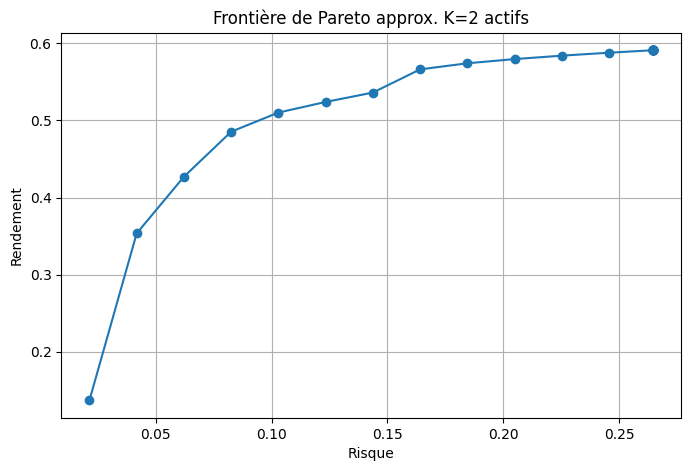

In [17]:
plt.figure(figsize=(8,5))
plt.plot(frontier_volatilities, frontier_returns, marker='o')
plt.xlabel('Risque')
plt.ylabel('Rendement')
plt.title(f'Frontière de Pareto approx. K={K} actifs')
plt.grid(True)
plt.show()

# Génération de la Frontière Efficiente

En faisant varier $ \lambda $ de 0 à 1, nous obtenons différents portefeuilles optimaux.


In [18]:
print("Le portefeuille avec le rendement le plus élevé :")
max_return_index = np.argmax(frontier_returns)
print(f"Rendement : {frontier_returns[max_return_index]:.4f}, Volatilité : {frontier_volatilities[max_return_index]:.4f}")
weights = frontier_weights[max_return_index]
weights[weights < 1e-4] = 0  # Nettoyer les poids très faibles pour l'affichage
print(f"Actifs sélectionnés :")
for i, weight in enumerate(weights):
    if weight > 0:
        print(f"  {df.columns[i]} : {weight:.4f}")
#print(f"Poids : {weights}")

print("\nLe portefeuille avec le risque le plus faible :")
min_risk_index = np.argmin(frontier_volatilities)
print(f"Rendement : {frontier_returns[min_risk_index]:.4f}, Volatilité : {frontier_volatilities[min_risk_index]:.4f}")
weights = frontier_weights[min_risk_index]
weights[weights < 1e-4] = 0  # Nettoyer les poids très faibles pour l'affichage
print(f"Actifs sélectionnés :")
for i, weight in enumerate(weights):
    if weight > 0:
        print(f"  {df.columns[i]} : {weight:.4f}")
#print(f"Poids : {weights}")

Le portefeuille avec le rendement le plus élevé :
Rendement : 0.5910, Volatilité : 0.2647
Actifs sélectionnés :
  NVDA : 1.0000

Le portefeuille avec le risque le plus faible :
Rendement : 0.1373, Volatilité : 0.0214
Actifs sélectionnés :
  PEP : 0.7007
  WMB : 0.2993


est ce que on peut pas relaxer une conteainte de cardinalité par une pénalisation L1 ? Si oui sous quelle condition ?
Oui, il est possible de relaxer une contrainte de cardinalité en utilisant une pénalisation L1, mais cela dépend de certaines conditions. La contrainte de cardinalité impose une limite sur le nombre d'actifs non nuls dans un portefeuille, ce qui est une contrainte non convexe et difficile à gérer directement dans les problèmes d'optimisation. En revanche, la pénalisation L1 (ou régularisation Lasso) encourage la sparsité dans les solutions en ajoutant une pénalité proportionnelle à la somme des valeurs absolues des coefficients (poids des actifs dans le portefeuille).

In [ ]:
import cvxpy as cp
import numpy as np

# ----------------------------
# Données du problème
# ----------------------------
# mu : espérance des rendements (190x1)
# Sigma : matrice de covariance (190x190)
# K : nombre maximum d'actifs sélectionnés
# epsilons : liste des niveaux de risque imposés

np.random.seed(0)
n = 190

mu = np.random.rand(n)          # Exemple (remplace avec tes données)
Sigma = np.random.rand(n,n)
Sigma = Sigma.T @ Sigma         # Rend Sigma semi-définie positive
K = 20                          # Cardinalité max (à adapter)
epsilons = np.linspace(0.001, 0.05, 20)   # Niveaux de risque

# ----------------------------
# Variables du modèle
# ----------------------------
w = cp.Variable(n)            # pondérations du portefeuille
z = cp.Variable(n, boolean=True)   # variables binaires pour la cardinalité

# Résultats stockés
frontier_returns = []
frontier_risks = []
weights = []

for eps in epsilons:

    # ----------------------------
    # Problème ε-contraint
    # ----------------------------
    objective = cp.Minimize(-mu @ w)   # Minimiser F1 = -w^T mu (maximiser le rendement)

    constraints = [
        cp.sum(w) == 1,                # Somme des poids = 1
        w >= 0,                        # Long-only (à adapter)
        w <= z,                        # Lie w et z (si z=0 => w=0)
        cp.sum(z) <= K,                # Cardinalité
        cp.quad_form(w, Sigma) <= eps, # Risque F2 <= epsilon
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.GUROBI, verbose=False)

    if problem.status not in ["optimal", "optimal_inaccurate"]:
        print(f"Pas de solution pour epsilon = {eps}")
        continue

    # Stockage des solutions
    w_val = w.value
    risk_val = w_val.T @ Sigma @ w_val
    ret_val = mu @ w_val

    frontier_returns.append(ret_val)
    frontier_risks.append(risk_val)
    weights.append(w_val)

# ----------------------------
# Résultats
# ----------------------------

print("Frontière de Pareto calculée.")
print("Rendements:", frontier_returns)
print("Risques:", frontier_risks)
